In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Load Data

In [17]:
clean = np.loadtxt('wifi_db/clean_dataset.txt')
np.random.shuffle(clean)
print(clean.shape)
noisy = np.loadtxt('wifi_db/noisy_dataset.txt')
np.random.shuffle(noisy)
print(noisy.shape) 

(2000, 8)
(2000, 8)


### Function Declarations

In [18]:

def FIND_SPLIT(data_set: np.ndarray) -> tuple:
    '''
    The function FIND_SPLIT chooses the attribute and the value that results in the highest information gain.

    Inputs: data_set, an np.ndarray of the data set to split. The last column is assumed to be the class label
    Outputs: tuple consisting of the attribute and value to split the data for the highest information gain
    '''


    def informationGain(data_set_full: np.ndarray, data_set_left: np.ndarray, data_set_right: np.ndarray) -> float:
        '''
        informationGain takes the full data set, and the two subsets which it is divided into. It returns the information gain.

        Inputs: data_set_full, np.ndarray of full dataset
                data_set_left, np.ndarray of left subsection of dataset
                data_set_right np.ndarray of right subsection of dataset
        Outputs: float, the information gain of the sectioning
        '''
        return entropy(data_set_full) - remainder(data_set_left, data_set_right)



    def entropy(data_set: np.ndarray) -> float:
        '''
        Calculates the entropy of a dataset.

        Inputs: data_set, where column with index -1 is assumed to be the label
        Outputs: float, the entropy of the data_set
        '''
        data_set = data_set[data_set[:, -1].argsort()]
        data_labels = data_set[:,-1]
        unique_labels = np.unique(data_labels)

        probabilities = np.zeros_like(unique_labels)

        for i, label in enumerate(unique_labels):
            probabilities[i] = np.sum(data_labels == label) / len(data_labels)

        entropy = - np.sum(np.log2(probabilities) * probabilities)
        
        return entropy



    def remainder(data_set_left: np.ndarray, data_set_right: np.ndarray) -> float:
        '''
        Calculates the remainder two subsets.

        Inputs: data_set_left, np.ndarray of the left subsection
                data_set_right, np.ndarray of the right subsection

        Outputs: float, the remainder of the subsections

        '''
        no_samples_left = len(data_set_left)
        no_samples_right = len(data_set_right)
        no_samples_tot = no_samples_left + no_samples_right

        entropy_left = entropy(data_set_left)
        entropy_right = entropy(data_set_right)

        remainder = no_samples_left * entropy_left / no_samples_tot + no_samples_right * entropy_right / no_samples_tot

        return remainder
    

    attributes = data_set.shape[1] - 1

    running_score = np.zeros((attributes, 2))

    for i in range(attributes):

        highest_information_gain = 0
        best_split = None

        data_set = data_set[data_set[:, i].argsort()]
        unique_values = np.unique(data_set[:, i])
        possible_splits = (unique_values[:-1] + unique_values[1:]) / 2

        for split in possible_splits:

            left_index = data_set[:, i] > split
            right_index = left_index == False

            data_set_left = data_set[left_index]
            data_set_right = data_set[right_index]

            information_gain = informationGain(data_set, data_set_left, data_set_right)

            if information_gain > highest_information_gain:
                highest_information_gain = information_gain
                best_split = split

        running_score[i,0] = highest_information_gain
        running_score[i,1] = best_split

    attribute_to_split = np.argmax(running_score[:, 0])
    split_value = running_score[attribute_to_split, 1]

    return (attribute_to_split, split_value)



def decisionTreeLearning(train_dataset: np.ndarray, depth: int = 0, max_depth: int = 100, min_samples_leaf: int = 1):
    '''
    Takes as arguments a matrix containing the dataset and a depth variable (which is used to compute the maximal depth
    of the tree, for plotting purposes for instance). The label of the training dataset is assumed to be the last
    column of the matrix.

    Inputs: train_dataset, np.ndarray
            depth, int, to keep track of how deep down the tree the node is
            max_depth, int which can be used to regularise the classifier
            min_samples_leaf, int, the minimum samples on a node before it becomes a leaf. Used for regularisation
    Outputs: node, dictionary
             depth, int

    '''

    if len(set(train_dataset[:, -1])) == 1:
        leaf_val = train_dataset[0,-1]
        #for leaf the leaf_vale is saved under the attribute key
        leaf_node = {'attribute': None, 'value': leaf_val,
                     'left': None, 'right': None, 'isLeaf': True}
        
        return leaf_node, depth
    
    if depth >= max_depth:
        counts = np.bincount(np.int64(train_dataset[:, -1]))
        leaf_val = np.argmax(counts)

        leaf_node = {'attribute': None, 'value': leaf_val,
                     'left': None, 'right': None, 'isLeaf': True}
        return leaf_node, depth
    
    if len(train_dataset[:, -1]) <= min_samples_leaf:
        counts = np.bincount(np.int64(train_dataset[:, -1]))
        leaf_val = np.argmax(counts)

        leaf_node = {'attribute': None, 'value': leaf_val,
                        'left': None, 'right': None, 'isLeaf': True}
        return leaf_node, depth 

    attribute, value = FIND_SPLIT(train_dataset)

    node = {'attribute': attribute, 'value': value, 'left': None, 'right': None, 'isLeaf': False}
   
    l_dataset = train_dataset[train_dataset[:, attribute] <= value]
    node['left'], l_depth = decisionTreeLearning(l_dataset, depth = depth+1, max_depth = max_depth, min_samples_leaf = min_samples_leaf) #shoud we sort this?

    r_dataset = train_dataset[train_dataset[:, attribute] > value]
    node['right'], r_depth = decisionTreeLearning(r_dataset, depth = depth+1, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
   
    return node, max(l_depth, r_depth)



def sampleClassification(root: dict, sample: np.ndarray) -> int:
    '''
    Classifies a sample using the decision tree

    Inputs: root, dictionary containing the root of the tree
            sample, np.ndarray containing the sample features
    Outputs: integer label for the sample
    '''
   
    if root['isLeaf']:
        #do the return instead of print int he future
        return root['value']
   
    col = root['attribute']
    val = root['value']

    if sample[col] <= val:
        return sampleClassification(root['left'], sample)
    else:
        return sampleClassification(root['right'], sample)




def decisionTreeClassifier(x_test, root):
    '''
    Takes a whole dataset and the root of the decision tree and labels each point. 
    Assumes the last column is true labels.

    Inputs: x_test, np.ndarray matrix containing test data
            root, dictionary containing the root of the decision tree
    Outputs: np.ndarray containing the predicted labels
    '''
    
    predictions = np.zeros(len(x_test))

    for i in range(len(x_test)):
        predictions[i] = sampleClassification(root, x_test[i,:-1])
    
    return predictions


 # TODO
def printTree(root, depth):
    'bonus question to print the tree, BFS based '
    np.full((2**depth),' ')
    pass

### Train the tree on the clean data

In [19]:
begin_root, _ = decisionTreeLearning(clean)

### Test tree on noisy data

In [20]:
pred = decisionTreeClassifier(noisy, begin_root)
accuracy = np.sum(pred == noisy[:,-1]) / len(noisy)
print('The accuracy on the testing data is: {}'.format(accuracy))

The accuracy on the testing data is: 0.918


### Plot tree

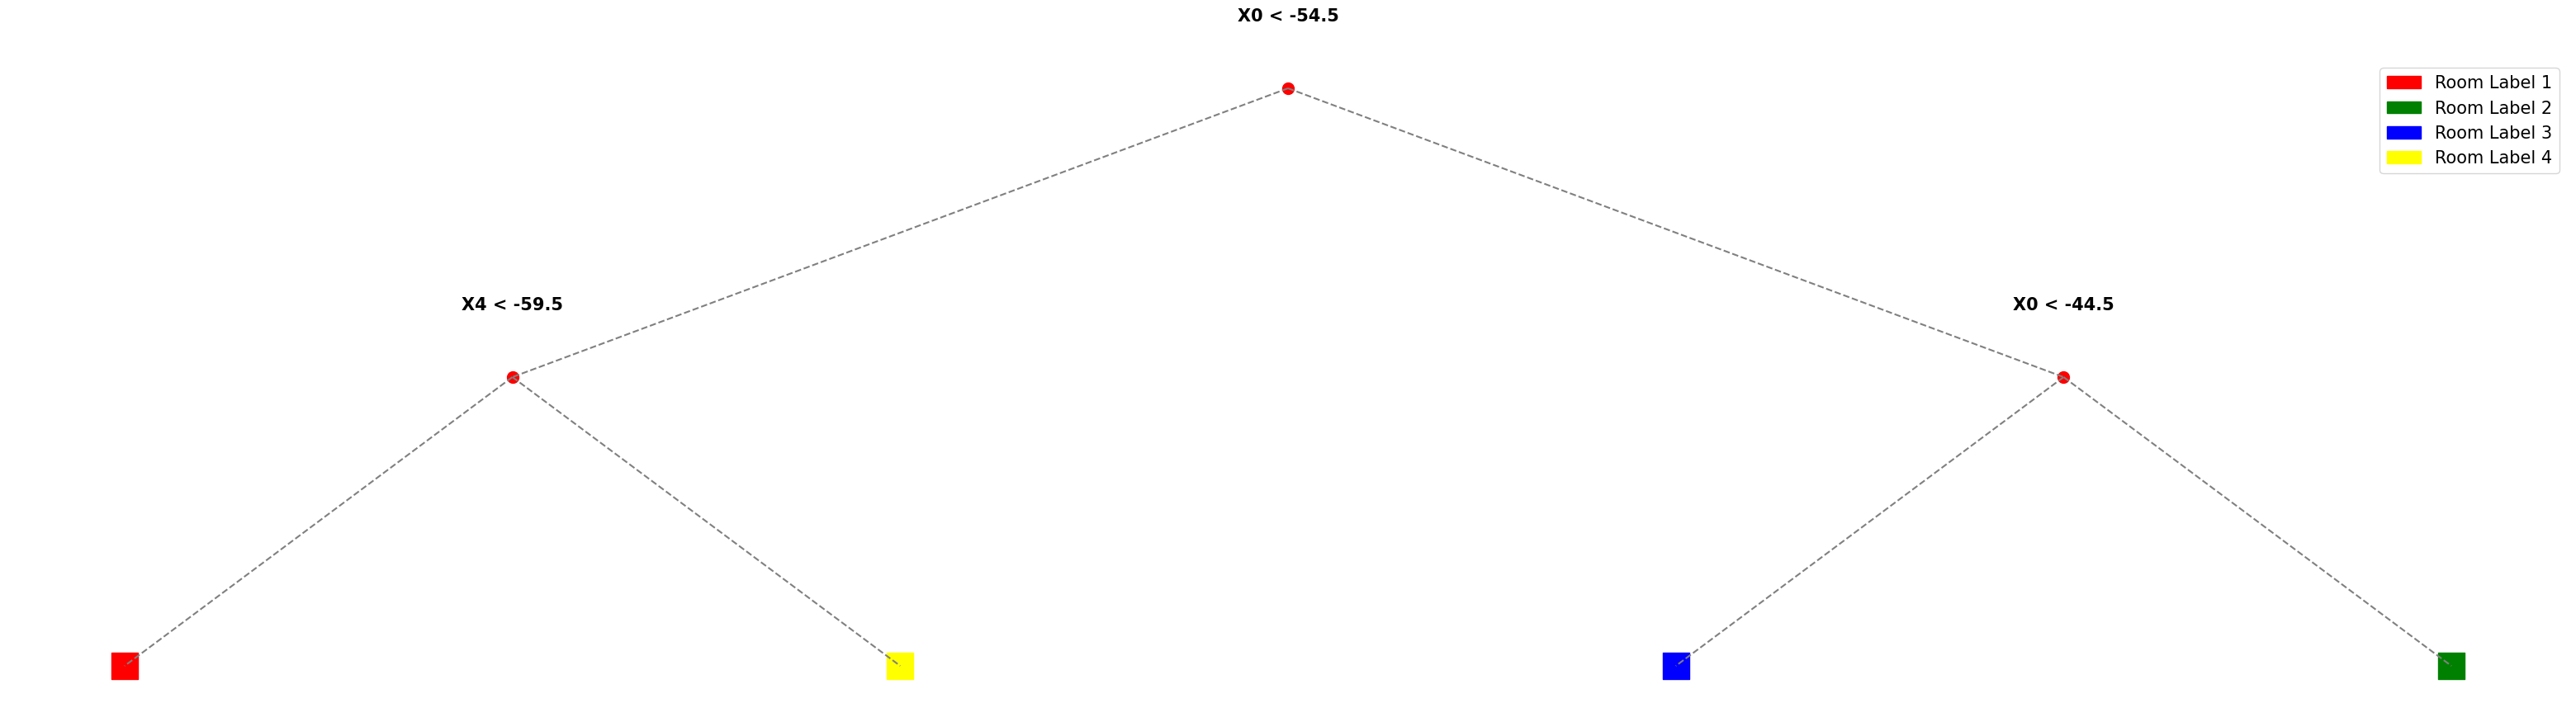

In [21]:
def plot_tree(begin_root):

    def  rec_plot_tree(node, parent_x, parent_y, width, depth, direction=None, colors = ['red', 'green', 'blue', 'yellow']):

        if direction == None:
            x = 0
            y = 0

        elif direction == 'right':
            x = parent_x + (width / 2)
            y = parent_y - depth

        elif direction == 'left':
            x = parent_x - (width / 2)
            y = parent_y - depth

        if not node['isLeaf']:

            # Plot Node and line from paren
            plt.plot([parent_x, x], [parent_y, y], '--', c = 'grey')
            plt.scatter(x, y, color = 'r', s = 100)
            plt.text(x, y+depth/4, "X{} < {}".format(node['attribute'], node['value']), ha='center', va='center', weight='bold')
            
            # Recursively plot the left and right subtrees
            rec_plot_tree(node["left"], x, y, width / 2, depth, "left")
            rec_plot_tree(node["right"], x, y, width / 2, depth, "right")

        elif node['isLeaf']:
            # If it's a leaf node, plot its class label, encoded by the color
            label = int(node['value'])
            c = colors[label - 1]

            # Plot leaf and line from parent
            plt.plot([parent_x, x], [parent_y, y], '--', c = 'grey')
            plt.scatter(x, y, color = c, marker='s', s = 500)



    # Create a figure and call the plot_tree function
    plt.figure(figsize=(40, 10))
    plt.rcParams.update({'font.size': 15})
    colors = ['red', 'green', 'blue', 'yellow']
    plt.axis('off')  # Turn off axis labels and ticks
    rec_plot_tree(begin_root, 0, 0, 2, 5, colors = ['red', 'green', 'blue', 'yellow'])

    # Create index
    patches = []
    for i in range(1, 5):
        patches.append(mpatches.Patch(color = colors[i-1], label = 'Room Label {}'.format(i)))
    plt.legend(handles = patches)

    plt.show()
    

# Tree to plot
begin_root, _ = decisionTreeLearning(clean, max_depth = 2)
plot_tree(begin_root)


### Pruning

In [22]:
begin_root, _ = decisionTreeLearning(clean)

def evaluate(root, validation_data):
    pred = decisionTreeClassifier(validation_data, root)
    return np.sum(pred == validation_data[:,-1]) / len(validation_data)

evaluate(begin_root, noisy)  

#add code here

0.918

In [23]:
import copy 

unpruned tree acc: 0.81


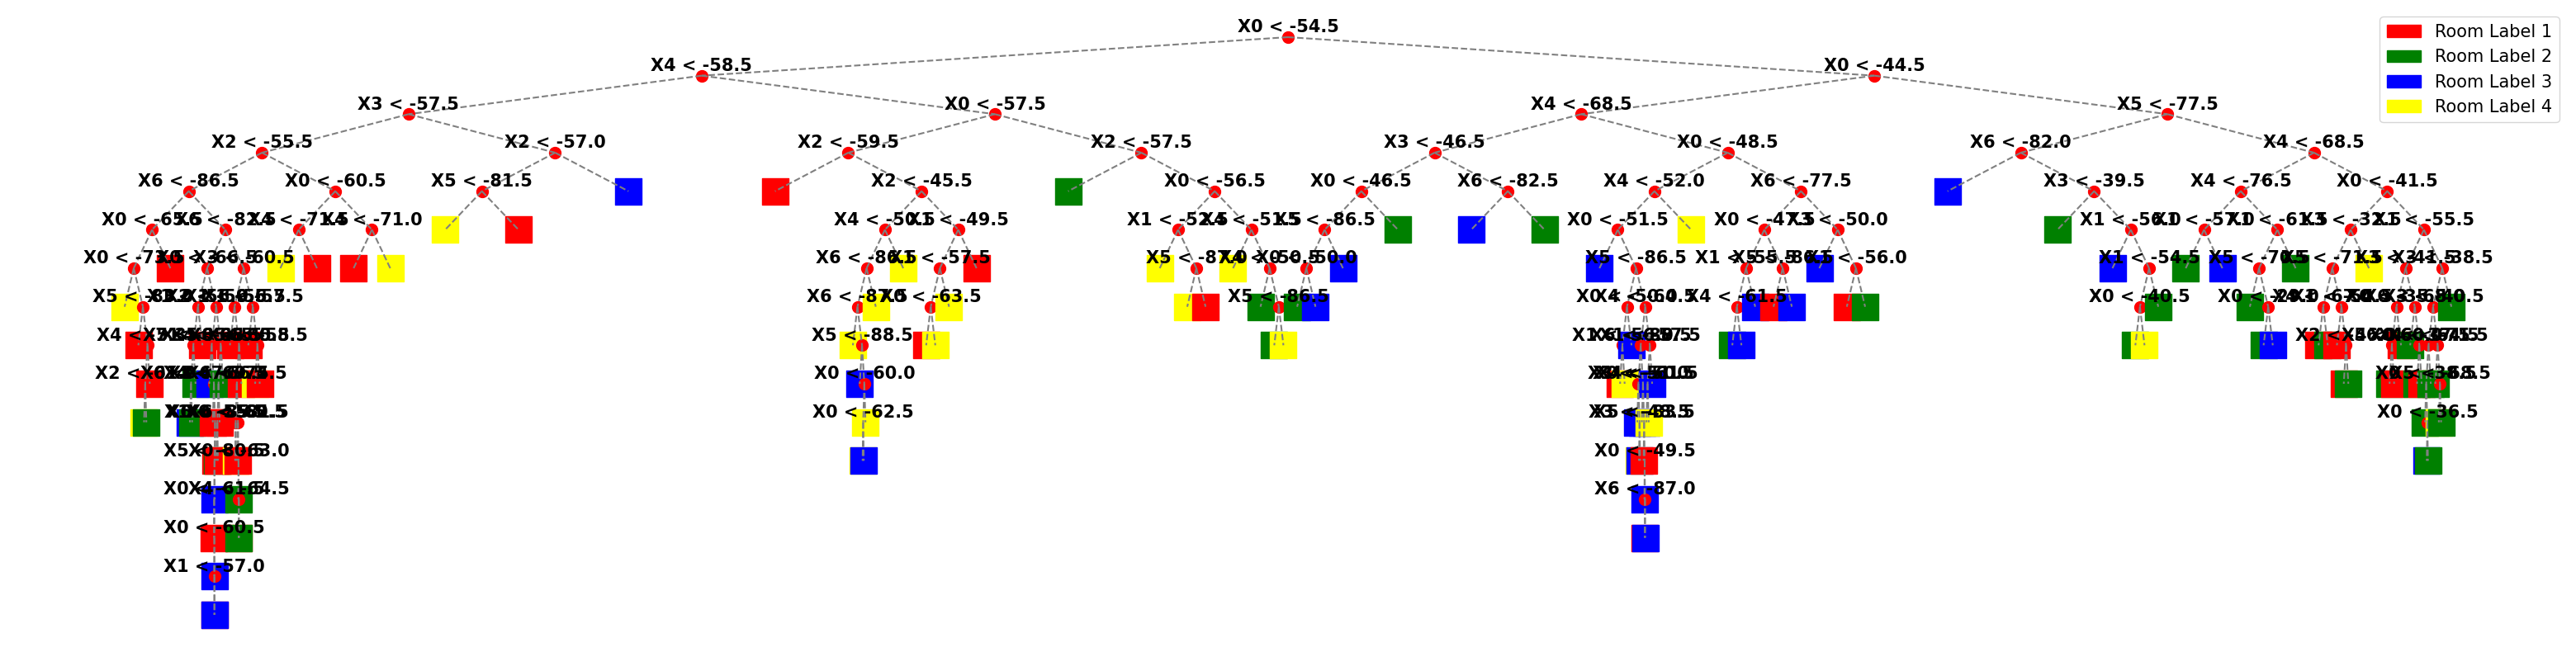

pruned tree acc: 0.8925


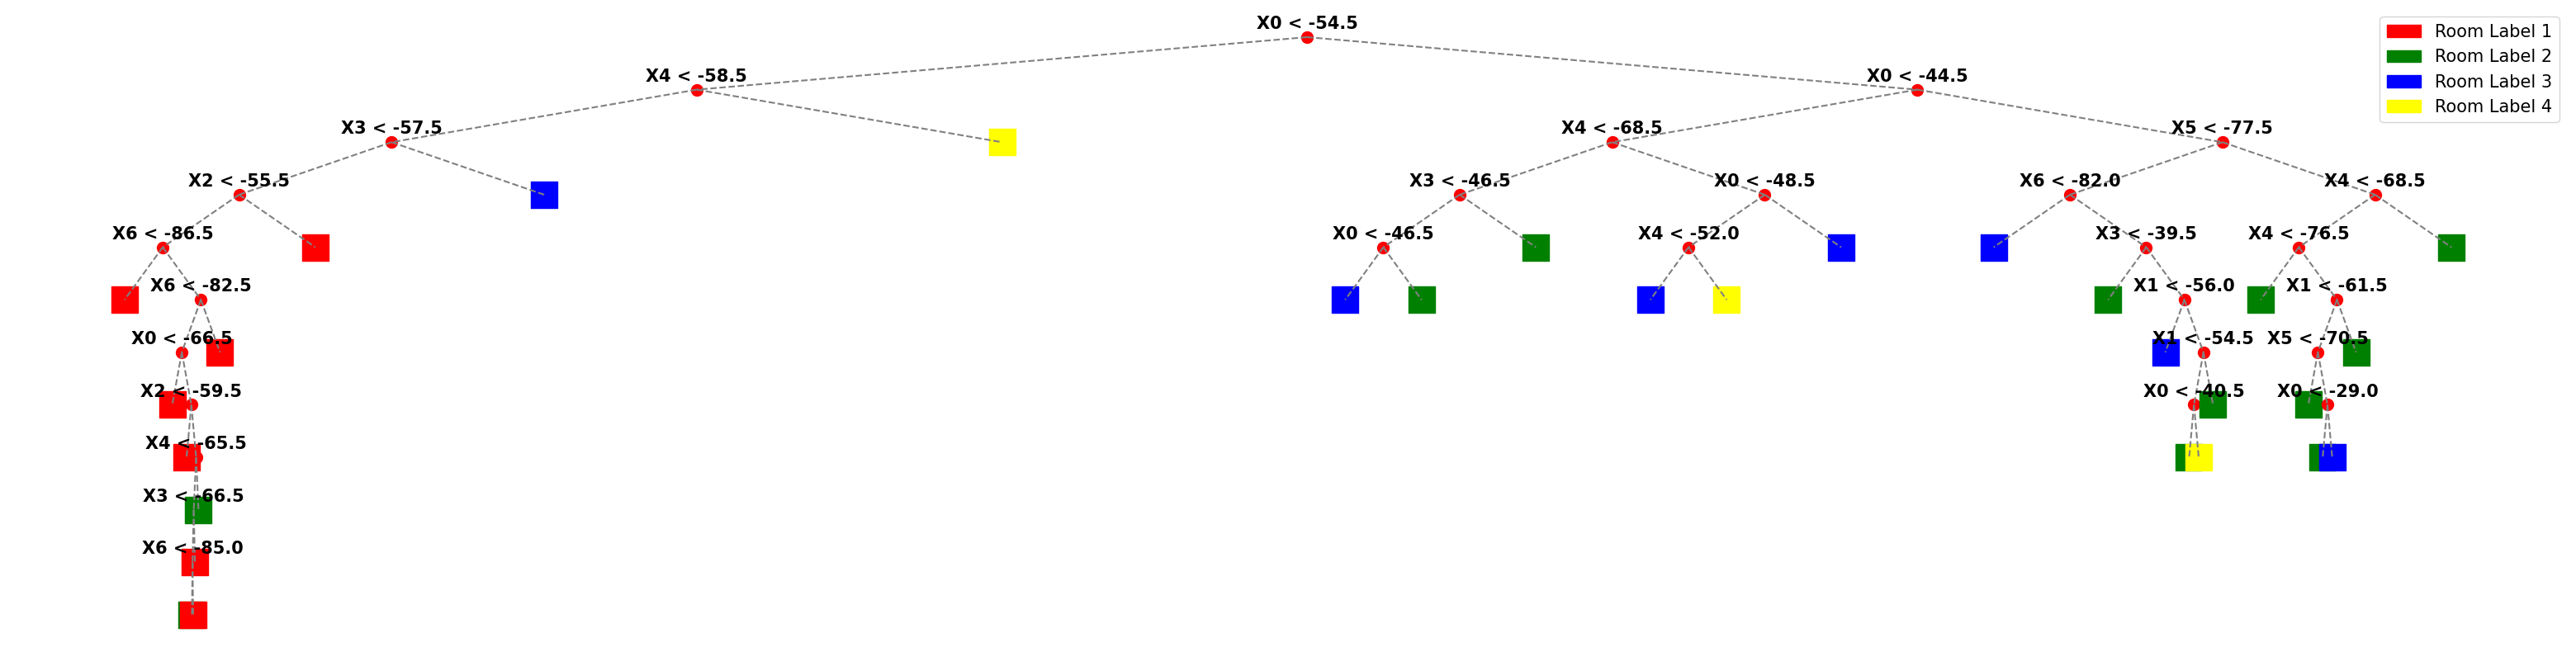

In [24]:
def decision_tree_acc(root, data_to_test):
    pred = decisionTreeClassifier(data_to_test, root)
    return np.sum(pred == data_to_test[:,-1]) / len(data_to_test)

def decisionTreePruning(begin_root, validation_data, pruning_iterations = 100) -> dict:
    '''
    output: pruned decision tree
    '''

    def prunDFS(root, validation_data, inference_data) -> None:
        '''output: None, proot (decision tree we want to return) is changed in place all the time)'''

        if not root or root['isLeaf']:
            return 
        assert root['left'], "no left child" 
        assert root['right'], "no right child"

        # Check if it is a parent of two leaves, and that we have validation data for majority vote
        # MAYBE: Set random like below if there is no validation data at node for vote? To enourage pruning
        # np.random.choice([root['left']['value'], root['right']['value']])
        if root['left']['isLeaf'] and root['right']['isLeaf'] and validation_data.shape[0] > 0:
            #node has two children and both are leafs
            #ideally choose the majority one
            acc = decision_tree_acc(begin_root, inference_data)
            root_back_l = root['left']
            root_back_r = root['right']
            root_back_val = root['value']

            root['value'] = np.bincount(validation_data[:, -1].astype(int)).argmax()  
            root['isLeaf'] = True
            root['left'] = None
            root['right'] = None
            acc_prunned = decision_tree_acc(begin_root, inference_data)
            
            if acc_prunned < acc:
                root['left'] = root_back_l
                root['right'] = root_back_r
                root['isLeaf'] = False
                root['value'] = root_back_val

        else:
            # Separate dataset into a left and right dataset
            limit_threshold = validation_data[:, root['attribute']] <= root['value']
            left_data = validation_data[limit_threshold]
            right_data = validation_data[limit_threshold == False]
            
            # Pass left and right data set
            prunDFS(root['left'], left_data, inference_data)
            prunDFS(root['right'], right_data, inference_data)

    for _ in range(pruning_iterations):
        prunDFS(
            root = begin_root,
            validation_data = validation_data,
            inference_data = validation_data
            )
    
    return begin_root


def decision_tree_acc(root, data_to_test):
    pred = decisionTreeClassifier(data_to_test, root)
    return np.sum(pred == data_to_test[:,-1]) / len(data_to_test)

root, _ = decisionTreeLearning(noisy[:800], max_depth=50)
print('unpruned tree acc:', decision_tree_acc(root, noisy[1600:]))

plot_tree(root)

proot = decisionTreePruning(root, noisy[800:1600])
print('pruned tree acc:', decision_tree_acc(proot, noisy[1600:]))

plot_tree(proot)

### Evaluate Pruning

In [25]:
def k_data_divide(data, ind_test, ind_val, number_folds = 10):
    # Split data into 10 equal length compartments
    folds = np.array_split(data, number_folds) #np.array_split(shuffled_data, 10)
    fold_test = folds[ind_test]
    fold_val = folds[ind_val]
    folds = np.delete(folds, [ind_test, ind_val], axis=0)
    fold_train = np.concatenate(folds)

    return fold_test, fold_val, fold_train

# Confusion Matrix

def plot_confusion_matrix(cm, class_labels, title):
  '''
    Takes a numpy array format of the confusion matrix and plots it neatly
    using matplotlib.

    Inputs: cm - array containing confusion matrix
            class_labels - list containing axis titles
            title - string containing title for cm
    Outputs: plots a confusion matrix
    '''
  plt.figure(figsize=(8,6))
  plt.imshow(cm, cmap = "GnBu")
  plt.title(title + ' Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(class_labels))
  plt.xticks(tick_marks, class_labels, rotation=45)
  plt.yticks(tick_marks, class_labels)
  for (j, i), label in np.ndenumerate(cm):
      plt.text(i, j, label, ha='center', va='center')
  plt.show()

def confusion_matrix(y_true, y_prediction, class_labels = []):
  '''
    Uses true and predicted values to calculate the confusion matrix.

    Inputs: y_true - array containing all the true labels
            y_pred - array containing all the predicted labels
    
    Outputs: cm - array containing the confusion matrix
             class_labels - appropriate labels for rows/column of matrix, useful for plotting
  '''
  if len(class_labels) <1:
    class_labels = np.unique(np.concatenate((y_true, y_prediction)))
  cm = np.zeros((len(class_labels), len(class_labels)))
  for (i, i_label) in enumerate(class_labels):
    true_index = (y_true == i_label)
    true = y_true[true_index]
    predictions = y_prediction[true_index]
    (unique_labels, counts) = np.unique(predictions, return_counts=True)
    cm_data = dict(zip(unique_labels, counts))

    for (j, j_label) in enumerate(class_labels):
      cm[i, j] = cm_data.get(j_label, 0)

  return cm, class_labels

def accuracy(cm):
    '''
      Computes the accuracy of the decision tree using the confusion matrix

      Inputs: cm - array containing the confusion matrix
      
      Outputs: np.sum(np.diag(cm)) / np.sum(cm) - The decision tree accuracy
              0 - if there is no cm the function simply returns 0
    '''
    if np.sum(cm) > 0:
      return np.sum(np.diag(cm)) / np.sum(cm)
    else:
      return 0

# Precision

def precision(cm):
  ''' 
    Computes the class precisions and macro precision of the decision tree using the confusion matrix
  
    Inputs: cm - array containing the confusion matrix

    Outputs: (p, macro_p) - tuple containing the class precisions as an array and the macro precision as a float
  '''
  p = np.zeros((len(cm)))
  for c in range(len(cm)):
    if np.sum(cm[:, c]) > 0:
      p[c] = cm[c, c] / np.sum(cm[:, c])
  macro_p = 0
  if len(p) > 0:
    macro_p = np.mean(p)
  return (p, macro_p)

# Recall

def recall(cm):
  ''' 
    Computes the class recall and macro recall of the decision tree using the confusion matrix
  
    Inputs: cm - array containing the confusion matrix

    Outputs: (r, macro_r) - tuple containing the class recall as an array and the macro recall as a float
  '''
  r = np.zeros((len(cm)))
  for c in range(len(cm)):
    if np.sum(cm[:, c]) > 0:
      r[c] = cm[c, c] / np.sum(cm[c, :])
  macro_r = 0
  if len(r) > 0:
    macro_r = np.mean(r)

  return (r, macro_r)

# F1 Measures

def f_measure(cm, beta=1):
  ''' 
    Computes the class f-measure and macro f-measure of the decision tree using the confusion matrix
  
    Inputs: cm - array containing the confusion matrix

    Outputs: (p, macro_p) - tuple containing the class precisions as an array and the macro precision as a float
  '''
  (precisions, macro_p) = precision(cm)
  (recalls, macro_r) = recall(cm)
  assert len(precisions) == len(recalls)
  f = np.zeros((len(precisions)))
  for c, (p, r) in enumerate(zip(precisions, recalls)):
    if p + r > 0:
      f[c] = (1 + beta**2) * p * r / ((beta**2 * p) + r)
  macro_f = 0
  if len(f) > 0:
    macro_f = np.mean(f)
  return (f, macro_f)

## Noisy Data

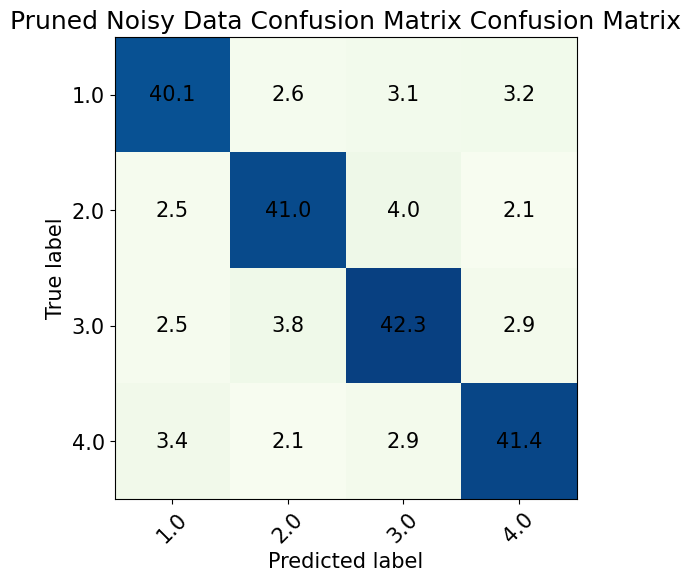

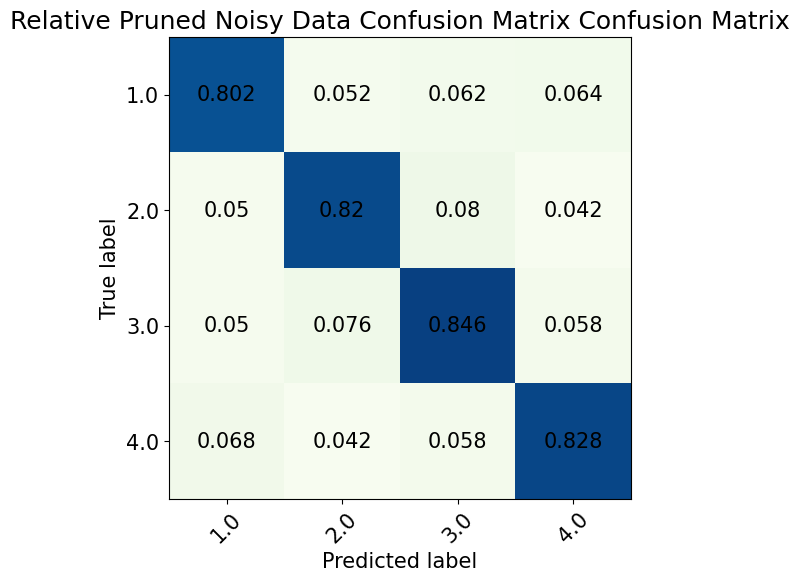

The Average unpruned accuracy is across all folds 0.795777777777778
The Average pruned accuracy is across all folds 0.8240555555555557


In [26]:
data_set_to_test = noisy

number_folds = 10
tree_number = 0
verbose = False 

cross_validation_accuracies_pruned = np.zeros(number_folds*(number_folds-1))
cross_validation_accuracies_unpruned = np.zeros(number_folds*(number_folds-1))

cm = np.zeros((4,4))
labels = np.unique(data_set_to_test[:, -1])


for ind_test in range(number_folds):
    for ind_val in range(number_folds):
        if ind_test == ind_val:
            continue
       
        # Get fold
        fold_test, fold_val, fold_train = k_data_divide(data_set_to_test, ind_test, ind_val)

        # Train on the training data
        root, _ = decisionTreeLearning(fold_train, max_depth=100)
        initial_root = copy.deepcopy(root)
        cv_accuracy_unpruned = decision_tree_acc(root, fold_test)
        cross_validation_accuracies_unpruned[tree_number] = cv_accuracy_unpruned
       
        # Prune on the validation data    
        proot = decisionTreePruning(root, fold_val)

        # Test pruned tree on testing data
        cv_accuracy_pruned = decision_tree_acc(proot, fold_test)
        cross_validation_accuracies_pruned[tree_number] = cv_accuracy_pruned

        # Get prediction from pruned test
        y_true = fold_test[:, -1]
        y_prediction = decisionTreeClassifier(fold_test, proot)
        
        # Add to total cm to average later on
        cm_addition, class_labels = confusion_matrix(y_true, y_prediction, class_labels = labels)

        cm = cm + cm_addition

        if cv_accuracy_pruned > cv_accuracy_unpruned and verbose:
            print('Pruning improved it')

        tree_number+=1
avg_cm = np.round(cm / (number_folds*(number_folds-1)), decimals=1)

plot_confusion_matrix(avg_cm, class_labels, "Pruned Noisy Data Confusion Matrix")

plot_confusion_matrix(np.round(avg_cm/50, decimals=3), class_labels, "Relative Pruned Noisy Data Confusion Matrix")


print('The Average unpruned accuracy is across all folds {}'.format(np.sum(cross_validation_accuracies_unpruned)/len(cross_validation_accuracies_unpruned)))
print('The Average pruned accuracy is across all folds {}'.format(np.sum(cross_validation_accuracies_pruned)/len(cross_validation_accuracies_pruned)))

In [28]:
print("Noisy Data")
print("Accuracy: " + str(accuracy(avg_cm)))
print("Precision: " + str(precision(avg_cm)))
print("Recall: " + str(recall(avg_cm)))
print("F-measure: " + str(f_measure(avg_cm)))

Noisy Data
Accuracy: 0.8244122061030514
Precision: (array([0.82680412, 0.82828283, 0.80879541, 0.83467742]), 0.8246399456097183)
Recall: (array([0.81836735, 0.8266129 , 0.82135922, 0.8313253 ]), 0.824416193667593)
F-measure: (array([0.8225641 , 0.82744702, 0.8150289 , 0.83299799]), 0.824509503858663)


## Clean Data

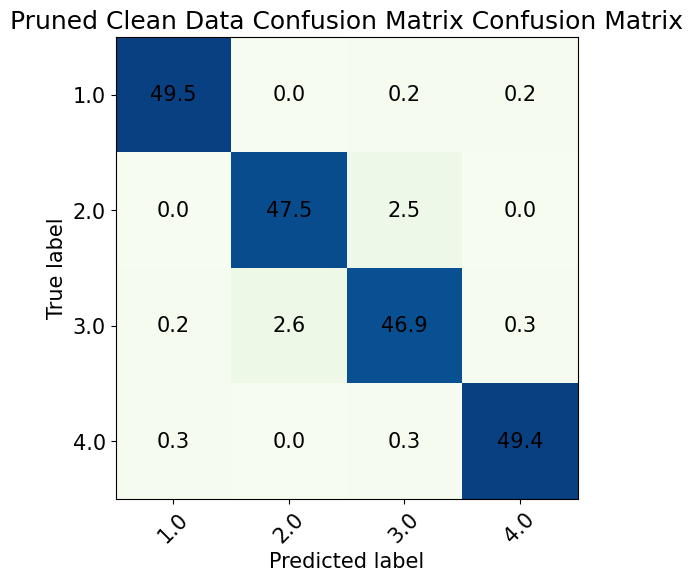

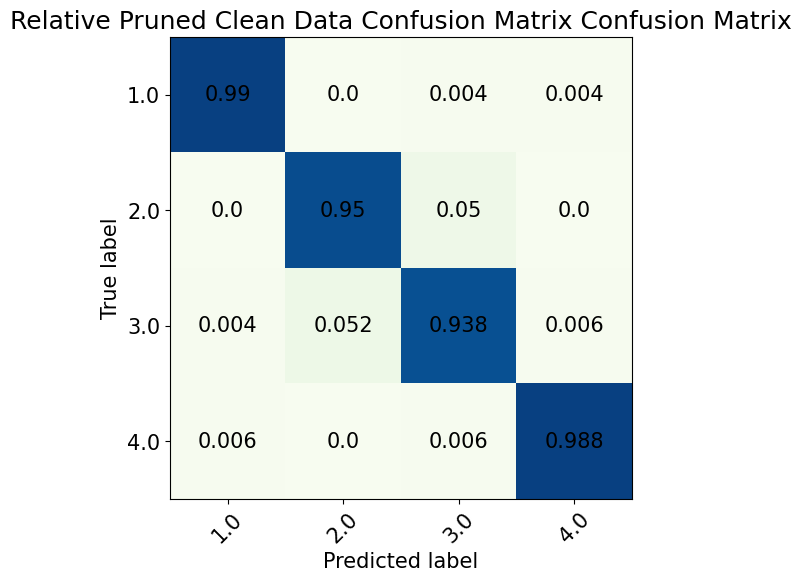

The Average unpruned accuracy is across all folds 0.9707777777777779
The Average pruned accuracy is across all folds 0.9665555555555554


In [29]:
data_set_to_test = clean

number_folds = 10
tree_number = 0
verbose = False 

cross_validation_accuracies_pruned = np.zeros(number_folds*(number_folds-1))
cross_validation_accuracies_unpruned = np.zeros(number_folds*(number_folds-1))

cm = np.zeros((4,4))
labels = np.unique(data_set_to_test[:, -1])


for ind_test in range(number_folds):
    for ind_val in range(number_folds):
        if ind_test == ind_val:
            continue
       
        # Get fold
        fold_test, fold_val, fold_train = k_data_divide(data_set_to_test, ind_test, ind_val)

        # Train on the training data
        root, _ = decisionTreeLearning(fold_train, max_depth=100)
        initial_root = copy.deepcopy(root)
        cv_accuracy_unpruned = decision_tree_acc(root, fold_test)
        cross_validation_accuracies_unpruned[tree_number] = cv_accuracy_unpruned
       
        # Prune on the validation data    
        proot = decisionTreePruning(root, fold_val)

        # Test pruned tree on testing data
        cv_accuracy_pruned = decision_tree_acc(proot, fold_test)
        cross_validation_accuracies_pruned[tree_number] = cv_accuracy_pruned

        # Get prediction from pruned test
        y_true = fold_test[:, -1]
        y_prediction = decisionTreeClassifier(fold_test, proot)
        
        # Add to total cm to average later on
        cm_addition, class_labels = confusion_matrix(y_true, y_prediction, class_labels = labels)

        cm = cm + cm_addition

        if cv_accuracy_pruned > cv_accuracy_unpruned and verbose:
            print('Pruning improved it')

        tree_number+=1

# Get average cm
avg_cm = np.round(cm / (number_folds*(number_folds-1)), decimals=1)
plot_confusion_matrix(avg_cm, class_labels, "Pruned Clean Data Confusion Matrix")

plot_confusion_matrix(np.round(avg_cm/50, decimals=3), class_labels, "Relative Pruned Clean Data Confusion Matrix")

print('The Average unpruned accuracy is across all folds {}'.format(np.sum(cross_validation_accuracies_unpruned)/len(cross_validation_accuracies_unpruned)))
print('The Average pruned accuracy is across all folds {}'.format(np.sum(cross_validation_accuracies_pruned)/len(cross_validation_accuracies_pruned)))

In [30]:
print("Clean Data")
print("Accuracy: " + str(accuracy(avg_cm)))
print("Precision: " + str(precision(avg_cm)))
print("Recall: " + str(recall(avg_cm)))
print("F-measure: " + str(f_measure(avg_cm)))

Clean Data
Accuracy: 0.966983491745873
Precision: (array([0.99      , 0.94810379, 0.93987976, 0.98997996]), 0.9669908779635118)
Recall: (array([0.99198397, 0.95      , 0.938     , 0.988     ]), 0.9669959919839679)
F-measure: (array([0.99099099, 0.94905095, 0.93893894, 0.98898899]), 0.966992466992467)
